# Setup

In [70]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from buffer import MultiModelActivationBuffer

from datasets import load_dataset
import torch as t

from nnsight import LanguageModel
from buffer import MultiModelActivationBuffer
from trainers.top_k import TopKTrainer, AutoEncoderTopK
from training import trainSAE
from einops import rearrange, einsum
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda:0"
dtype = t.bfloat16
t.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
layer = 4
out_batch_size = 4*4096

submodule_list = []
model_list = []
for step in [1, 128, 256, 512, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 143000]:
    model = LanguageModel(
        "EleutherAI/pythia-70m", 
        revision=f"step{step}", 
        trust_remote_code=False, 
        device_map=device,
        torch_dtype=dtype,
        )
    for x in model.parameters():
        x.requires_grad = False
    model_list.append(model)
    submodule_list.append(model.gpt_neox.layers[layer])
    
activation_dim = 512

dataset = load_dataset(
    'Skylion007/openwebtext', 
    split='train', 
    streaming=True,
    trust_remote_code=True
    )

class CustomData():
    def __init__(self, dataset):
        self.data = iter(dataset)

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.data)['text']

In [350]:
def display_top_contexts_for_feature(
   model,
   tokens,
   top_acts,
   top_inds,
   feature_id,
   num_to_show=10,
   left_context=20,
   right_context=5,
   min_opacity=0.2,
   minimal=False
):
   """
   Display the top activating contexts for a feature using HTML with translucent highlighting.
   Only shows one example per unique context.
   
   Args:
       model: HuggingFace model with tokenizer
       tokens: tensor of shape [batch, n_ctx] containing token ids
       top_acts: tensor of shape [batch, n_ctx, k] containing activation values
       top_inds: tensor of shape [batch, n_ctx, k] containing feature indices
       feature_id: which feature to analyze
       num_to_show: number of top contexts to display
       left_context: number of tokens to show before the max activation
       right_context: number of tokens to show after the max activation
       min_opacity: minimum opacity for highlighting
       minimal: if True, removes labels and spacing between contexts
   """
   import torch
   from IPython.display import HTML
   import html
   
   def get_color(act_value, max_act):
       """Generate translucent red color based on activation value."""
       if act_value == 0:
           return "rgba(0, 0, 0, 0)"
       opacity = min(1.0, max(min_opacity, act_value / max_act))
       return f"rgba(255, 0, 0, {opacity})"
   
   html_output = """
   <div style="font-family: monospace; background-color: #1a1a1a; padding: 20px;">
       <style>
           .token {
               display: inline;
               padding: 0;
               margin: 0;
               position: relative;
           }
           .token:hover .tooltip {
               display: block;
           }
           .tooltip {
               display: none;
               position: absolute;
               background: #333;
               color: white;
               padding: 0px 0px;
               border-radius: 0px;
               font-size: 12px;
               bottom: 100%;
               left: 50%;
               transform: translateX(-50%);
               white-space: nowrap;
               z-index: 1;
           }
           .context-box {
               padding: 10px;
               border: 1px solid #333;
               border-radius: 4px;
               background: #252525;
           }
           .context-box-minimal {
               padding: 3px;
               background: #252525;
           }
           .text-container {
               font-size: 0;
               word-spacing: 0;
               letter-spacing: 0;
           }
           .activation-label {
               color: #888;
               margin-bottom: 8px;
           }
       </style>
   """
   
   # Find positions where this feature appears in top_inds
   batch_idxs, pos_idxs, k_idxs = torch.where(top_inds == feature_id)
   
   # Get the activation values for this feature
   acts = top_acts[batch_idxs, pos_idxs, k_idxs]
   
   # Sort by activation value
   sorted_idxs = torch.argsort(acts, descending=True)
   
   # Keep track of seen contexts to ensure uniqueness
   seen_contexts = set()
   unique_contexts = []
   
   # Get unique contexts
   for idx in sorted_idxs:
       batch_idx = batch_idxs[idx]
       tok_pos = pos_idxs[idx]
       activation = acts[idx].item()
       
       # Get context window for comparison
       start_idx = max(0, tok_pos - left_context)
       end_idx = min(tokens.shape[1], tok_pos + right_context + 1)
       context_tokens = tokens[batch_idx, start_idx:end_idx].tolist()
       
       # Create a hashable representation of the context
       context_key = tuple(context_tokens)
       
       if context_key not in seen_contexts:
           seen_contexts.add(context_key)
           unique_contexts.append((batch_idx, tok_pos, activation))
           
           if len(unique_contexts) == num_to_show:
               break
   
   # Display each unique context
   for batch_idx, tok_pos, activation in unique_contexts:
       # Get context window
       start_idx = max(0, tok_pos - left_context)
       end_idx = min(tokens.shape[1], tok_pos + right_context + 1)
       context_tokens = tokens[batch_idx, start_idx:end_idx]
       
       box_class = "context-box-minimal" if minimal else "context-box"
       margin_style = "" if minimal else "margin: 20px 0;"
       
       html_output += f"""
       <div class="{box_class}" style="{margin_style}">"""
       
       if not minimal:
           html_output += f"""
           <div class="activation-label">activation: {activation:.4f}</div>"""
           
       html_output += """
           <div class="text-container">
       """
       
       # Process each token in the context
       for j, token in enumerate(context_tokens):
           text = model.tokenizer.decode([token])
           pos = start_idx + j
           
           if pos == tok_pos:
               # Max activation token
               color = get_color(activation, activation)
           elif pos in pos_idxs[batch_idxs == batch_idx]:
               # Other activations of this feature
               local_act_idx = torch.where((batch_idxs == batch_idx) & (pos_idxs == pos))[0][0]
               local_act = acts[local_act_idx].item()
               color = get_color(local_act, activation)
           else:
               # Regular context
               color = "rgba(0, 0, 0, 0)"
           
           tooltip_text = f"Activation: {activation:.4f}" if pos == tok_pos else ""
           
           html_output += f"""
               <span class="token" style="background-color: {color}; color: #fff; font-size: 16px;">
                   {html.escape(text)}
                   <span class="tooltip">{tooltip_text}</span>
               </span>"""
       
       html_output += """
           </div>
       </div>
       """
   
   html_output += "</div>"
   return HTML(html_output)

In [73]:
def concat(x):
    return rearrange(x, 'b n d -> b (n d)')
def unconcat(x):
    return rearrange(x, 'b (n d) -> b n d', n=len(model_list))

In [74]:
ae_narrow = AutoEncoderTopK.from_hf("jacobcd52/features_over_time_narrow", k=128, device=device)
ae_wide = AutoEncoderTopK.from_hf("jacobcd52/features_over_time_wide", k=128, device=device)

/root/features_over_time/notebooks/../trainers/top_k.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(path)


In [206]:
# Get top acts and inds for both autoencoders, for making dashboards later
n_batches = 10

# WIDE
tokens_wide = []
top_acts_wide = []
top_inds_wide = []

buffer = MultiModelActivationBuffer(
    data=CustomData(dataset),
    model_list=model_list,
    submodule_list=submodule_list,
    d_submodule=activation_dim, # output dimension of the model component
    n_ctxs=256,  # you can set this higher or lower dependong on your available memory
    device=device,
    refresh_batch_size=128,
    out_batch_size=out_batch_size,
    remove_bos=True
)

buffer.rescale_acts = True
buffer.act_mean = ae_wide.act_mean.cpu()
buffer.act_std = ae_wide.act_std.cpu()

for _ in tqdm(range(n_batches)):
    
    x, tokens_batch = buffer.get_seq_batch()
    _, top_acts_wide_batch, top_inds_wide_batch, _ = ae_wide.encode(x, return_topk=True) 
    top_acts_wide.append(top_acts_wide_batch)
    top_inds_wide.append(top_inds_wide_batch)
    tokens_wide.append(tokens_batch)


tokens_wide = t.cat(tokens_wide)
top_acts_wide = t.cat(top_acts_wide)
top_inds_wide = t.cat(top_inds_wide)

print(tokens_wide.shape, top_acts_wide.shape, top_inds_wide.shape)


# NARROW
buffer = MultiModelActivationBuffer(
    data=CustomData(dataset),
    model_list=model_list,
    submodule_list=submodule_list,
    d_submodule=activation_dim, # output dimension of the model component
    n_ctxs=256,  # you can set this higher or lower dependong on your available memory
    device=device,
    refresh_batch_size=128,
    out_batch_size=out_batch_size,
    remove_bos=True
)

buffer.rescale_acts = True
buffer.act_mean = ae_narrow.act_mean.cpu()
buffer.act_std = ae_narrow.act_std.cpu()

tokens_narrow = []
top_acts_narrow = []
top_inds_narrow = []

for _ in tqdm(range(n_batches)):

    x, tokens_batch = buffer.get_seq_batch()
    _, top_acts_narrow_batch, top_inds_narrow_batch, _ = ae_narrow.encode(x, return_topk=True) 
    top_acts_narrow.append(top_acts_narrow_batch)
    top_inds_narrow.append(top_inds_narrow_batch)
    tokens_narrow.append(tokens_batch)

tokens_narrow = t.cat(tokens_narrow)
top_acts_narrow = t.cat(top_acts_narrow)
top_inds_narrow = t.cat(top_inds_narrow)

print(tokens_narrow.shape, top_acts_narrow.shape, top_inds_narrow.shape)

100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


torch.Size([1280, 127]) torch.Size([1280, 127, 128]) torch.Size([1280, 127, 128])


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]

torch.Size([1280, 127]) torch.Size([1280, 127, 128]) torch.Size([1280, 127, 128])


# Decoder projections

In [287]:
dec_narrow = rearrange(ae_narrow.decoder.weight, "(n_models d) d_hid -> d_hid n_models d", n_models=len(model_list))
dec_wide = rearrange(ae_wide.decoder.weight, "(n_models d) d_hid -> d_hid n_models d", n_models=len(model_list))
dec_narrow.shape, dec_wide.shape

power_wide = dec_wide.pow(2).sum(-1)
power_narrow = dec_narrow.pow(2).sum(-1)

# power_wide /= power_wide.mean(0)
# power_narrow /= power_narrow.mean(0)

Wide: 69% of features are dataset features


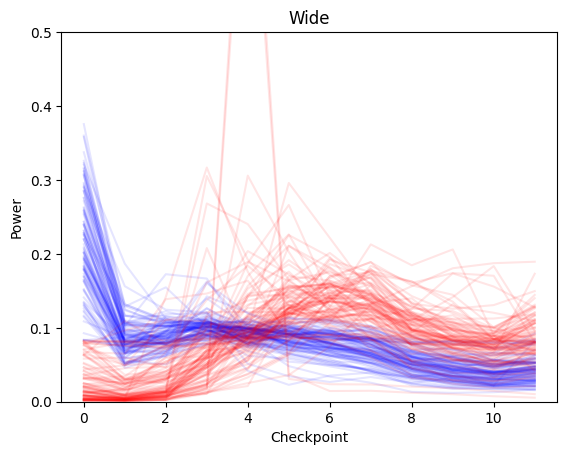

Narrow: 64% of features are dataset features


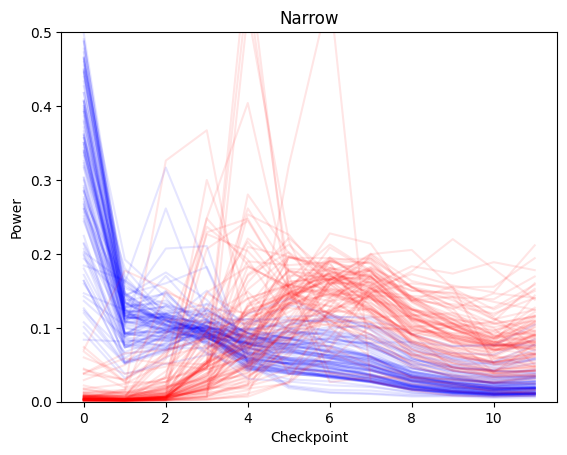

In [345]:
cpower_wide = power_wide.cumsum(-1)
is_dataset_feature_wide = power_wide[:, 0] > 1/12 # power_wide.argmax(-1) < 2
dataset_power_wide = power_wide[is_dataset_feature_wide]
new_power_wide = power_wide[~is_dataset_feature_wide]

print(f"Wide: {is_dataset_feature_wide.float().mean()*100:.0f}% of features are dataset features")
for i in range(100):
    plt.plot(dataset_power_wide[i].detach().cpu(), color='blue', alpha=0.1)

for i in range(100):
    plt.plot(new_power_wide[i].detach().cpu(), color='red', alpha=0.1)

plt.ylim(0, 0.5)
plt.xlabel('Checkpoint')
plt.ylabel('Power')
plt.title('Wide')

plt.show()


cpower_narrow = power_narrow.cumsum(-1)
is_dataset_feature_narrow = power_narrow[:, 0] > 1/12 # power_narrow.argmax(-1) < 2
dataset_power_narrow = power_narrow[is_dataset_feature_narrow]
new_power_narrow = power_narrow[~is_dataset_feature_narrow]

print(f"Narrow: {is_dataset_feature_narrow.float().mean()*100:.0f}% of features are dataset features")
for i in range(100):
    plt.plot(dataset_power_narrow[i].detach().cpu(), color='blue', alpha=0.1) 

for i in range(100):
    plt.plot(new_power_narrow[i].detach().cpu(), color='red', alpha=0.1)

plt.ylim(0, 0.5)
plt.xlabel('Checkpoint')
plt.ylabel('Power')
plt.title('Narrow')

plt.show()

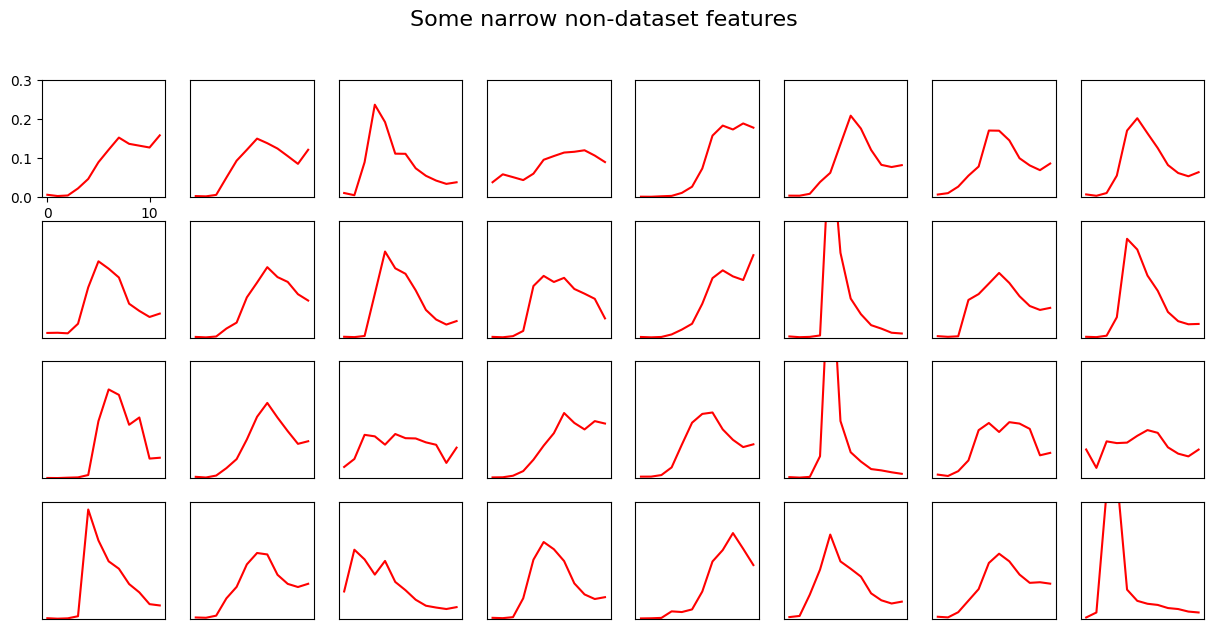

In [346]:
fig, axs = plt.subplots(4, 8, figsize=(15, 7))
for i in range(32):
    ax = axs[i//8, i%8]
    ax.plot((new_power_narrow[i]).detach().cpu(), color='red', alpha=1)
    ax.set_ylim(0, 0.3)
    if i > 0:
        ax.set_yticks([])
        ax.set_xticks([])

fig.suptitle('Some narrow non-dataset features', fontsize=16)
plt.show()

Text(0.5, 0.98, 'Some wide non-dataset features')

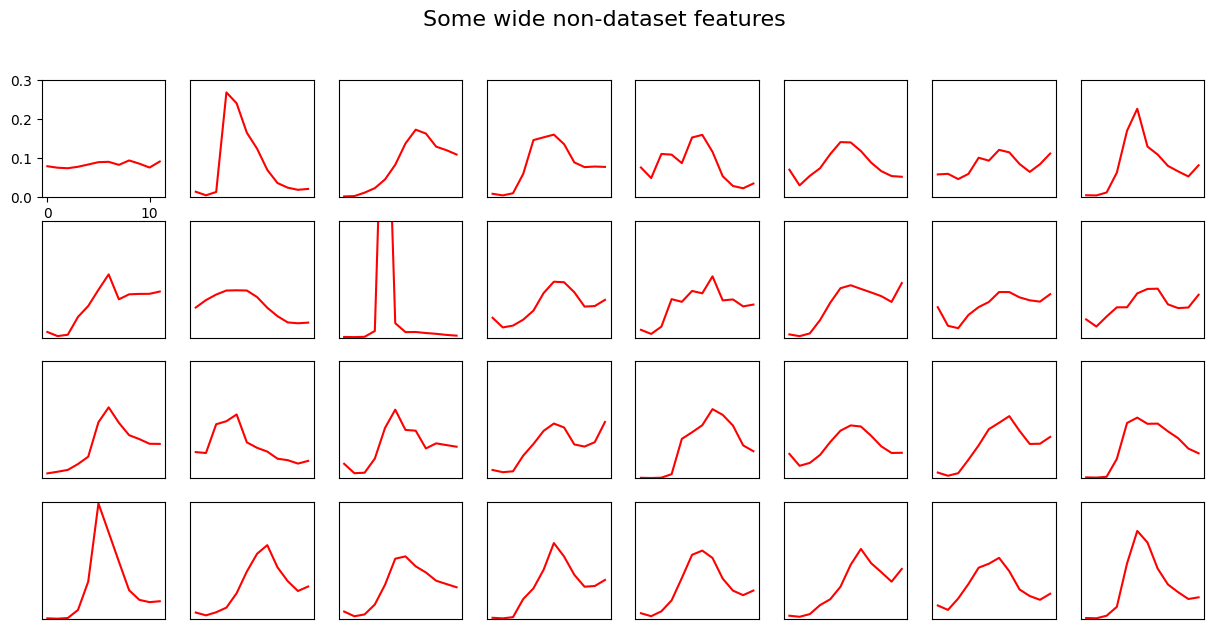

In [347]:
fig, axs = plt.subplots(4, 8, figsize=(15, 7))
for i in range(32):
    ax = axs[i//8, i%8]
    ax.plot(new_power_wide[i].detach().cpu(), color='red', alpha=1)
    ax.set_ylim(0, 0.3)
    if i > 0:
        ax.set_yticks([])
        ax.set_xticks([])
fig.suptitle('Some wide non-dataset features', fontsize=16)

(0.0, 0.3)

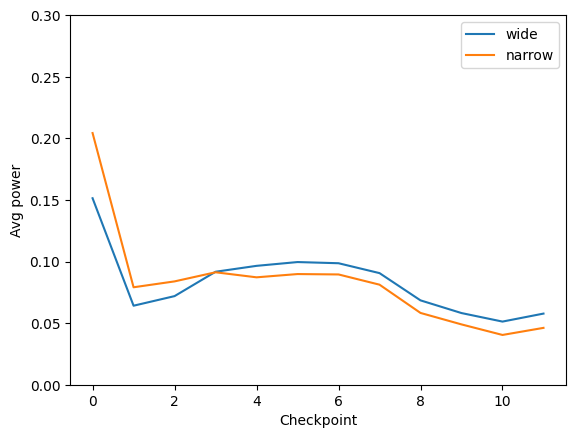

In [330]:
plt.plot(power_wide.mean(0).detach().cpu())
plt.plot(power_narrow.mean(0).detach().cpu())
# add legend
plt.legend(['wide', 'narrow'])

# add x axis
plt.xlabel('Checkpoint')

# add y axis
plt.ylabel('Avg power')
# set y lim
plt.ylim(0, 0.3)

In [331]:
buffer.rescale_acts = True
buffer.act_mean = ae_wide.act_mean.cpu()
buffer.act_std = ae_wide.act_std.cpu()

n_batches = 10
overall_fvu = 0
fvu = t.zeros(len(model_list)).cuda()

for _ in tqdm(range(n_batches)):
    x = next(buffer)
    x_hat = ae_wide(x)
    overall_fvu += (x - x_hat).var(0).sum() / x.var(0).sum()

    # now per checkpoint
    x = unconcat(x)
    x_hat = unconcat(x_hat)
    fvu += (x - x_hat).var(0).sum(-1) / x.var(0).sum(-1)

overall_fvu_wide = overall_fvu = n_batches
fvu_wide = fvu / n_batches

100%|██████████| 10/10 [00:35<00:00,  3.53s/it]


In [332]:
buffer.rescale_acts = True
buffer.act_mean = ae_narrow.act_mean.cpu()
buffer.act_std = ae_narrow.act_std.cpu()

n_batches = 10
overall_fvu = 0
fvu = t.zeros(len(model_list)).cuda()

for _ in tqdm(range(n_batches)):
    x = next(buffer)
    x_hat = ae_narrow(x)
    overall_fvu += (x - x_hat).var(0).sum() / x.var(0).sum()

    # now per checkpoint
    x = unconcat(x)
    x_hat = unconcat(x_hat)
    fvu += (x - x_hat).var(0).sum(-1) / x.var(0).sum(-1)

overall_fvu_narrow = overall_fvu = n_batches
fvu_narrow = fvu / n_batches

100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


(0.0, 0.3)

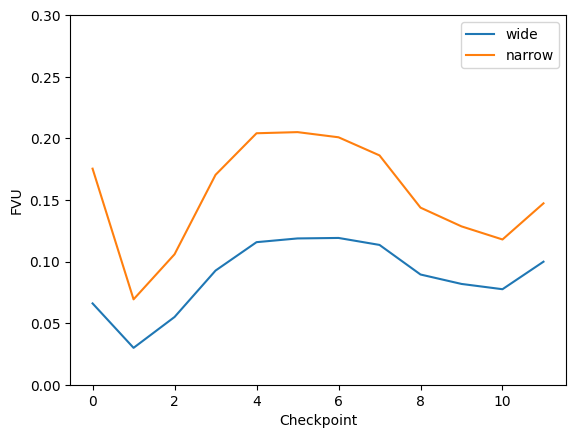

In [334]:
plt.plot(fvu_wide.detach().cpu())
plt.plot(fvu_narrow.detach().cpu())
# add legend
plt.legend(['wide', 'narrow'])
# add axis labels
plt.xlabel('Checkpoint')
plt.ylabel('FVU')
# set y lim
plt.ylim(0, 0.3)

# Dashboards

In [325]:
appear_wide = (power_wide > 1/12).float().argmax(-1)
appear_narrow = (power_narrow > 1/12).float().argmax(-1)

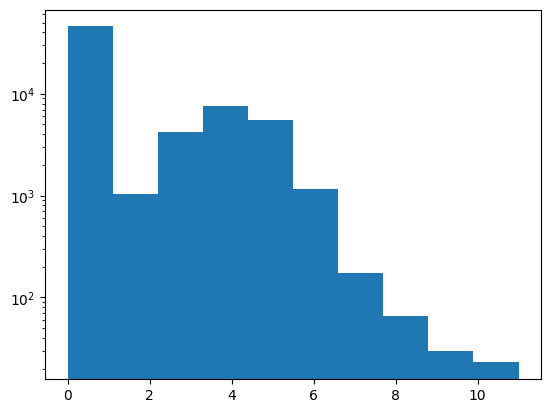

In [326]:
plt.hist(appear_wide.detach().cpu())
# make axes log
plt.yscale('log')
plt.show()

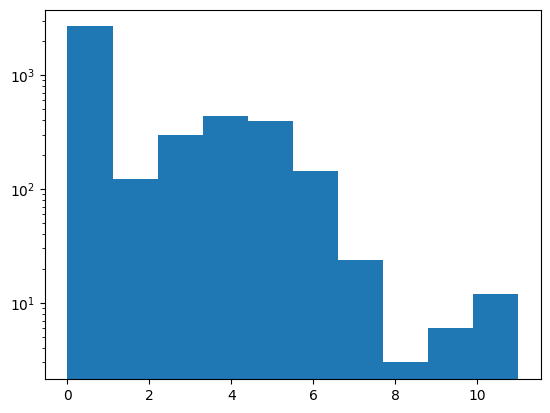

In [327]:
plt.hist(appear_narrow.detach().cpu())
# make axes log
plt.yscale('log')
plt.show()

In [ ]:
t.where(power_wide[:, 11] > 0.5)[0]

tensor([ 1086,  5452, 16685, 16934, 22577, 23520, 25429, 28897, 32021, 36414,
        42746, 45647, 47055, 49105, 51903, 61225, 65392], device='cuda:0')

In [ ]:
display_top_contexts_for_feature(
    model_list[0],
    tokens_wide,
    top_acts_wide,
    top_inds_wide,
    feature_id=102,
    left_context=15,
    right_context=3,
    minimal=True
)

In [186]:
ae_wide.act_std

tensor([[11.3750],
        [18.3750],
        [15.4375],
        [12.7500],
        [12.6875],
        [17.6250],
        [22.2500],
        [26.8750],
        [32.7500],
        [34.0000],
        [30.5000],
        [14.4375]], device='cuda:0')

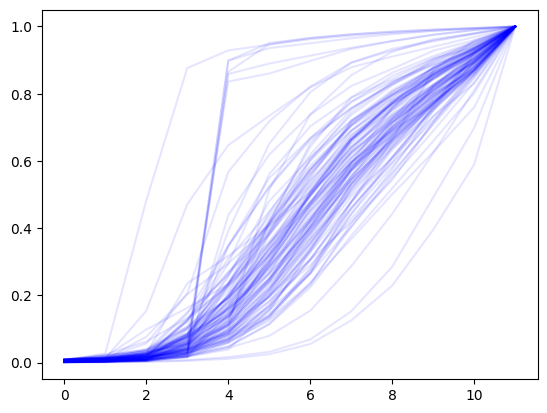

In [262]:
for i in range(1000):
    if power_wide[i, 0] < 0.01:
        plt.plot(cpower_wide.detach().cpu()[i], color='blue', alpha=0.1)

In [271]:
# For each feature, find first entry yof cpower_wide that exceeds 0.5
appear = (cpower_wide > 0.2).float().argmax(-1)
appear.shape

torch.Size([65536])

(array([3.9213e+04, 7.3190e+03, 4.7300e+03, 6.6100e+03, 5.7680e+03,
        1.5540e+03, 2.4300e+02, 6.7000e+01, 1.9000e+01, 1.3000e+01]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

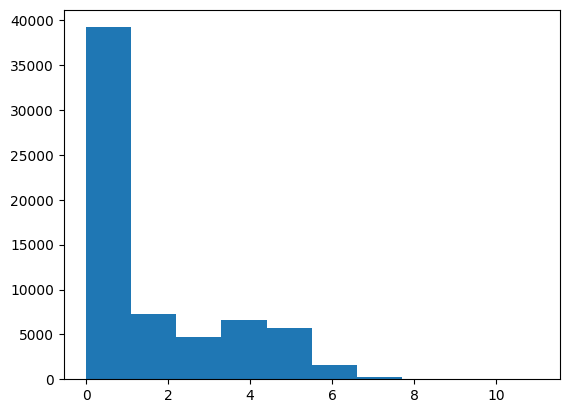

In [272]:
plt.hist(appear.detach().cpu())